In [1]:
# go wide screen

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
def pp(s):
    print(s)
    return s + "\n"

# Datamodel for the flow network

In [4]:
# Add current working directory to pythonpath
import sys
sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/ETS/real_test")

# Next two lines forc outomatic reload of loaded module. Convenient if
# one is still fiddeling with them.
%load_ext autoreload
%autoreload 2

import pfs_netflow.datamodel as dm

# Read the catalogs, compute visibility ... 

In [5]:
#BLOCKLENGTH = 300. # block exposure time in s, to simulate three consequtive exposures
BLOCKLENGTH = 900. # block exposure time in s

In [6]:
# Define target lists.
fscience_targets = "../../ETS/pfs_target_list/pfs_preliminary_target_cosmology.dat"
fcal_stars       = "../../ETS/pfs_target_list/pfs_preliminary_target_cosmology_fcstars.dat"
fsky_pos         = "../../ETS/pfs_target_list/pfs_preliminary_target_cosmology_sky.dat"

# Load target lists.
from astropy.io import ascii

science_targets = ascii.read(fscience_targets)

cal_stars = ascii.read(fcal_stars)

sky_pos = ascii.read(fsky_pos)

# Conversion of column names, this should not be necessary anymore in future versions.
for t in [science_targets, cal_stars, sky_pos]:
    t['R'].name = 'RA'
    t['Dec'].name = 'DEC'
    t['Exposure'].name = 'EXP_TIME'

In [7]:
# Convert data to lists for ETS.
import numpy as np
from numpy import hstack
from numpy import cos, deg2rad, sqrt
from numpy import unique, array


ID         = hstack([science_targets['ID'],cal_stars['ID'],sky_pos['ID']])
ra         = hstack([science_targets['RA'],cal_stars['RA'],sky_pos['RA']])
dec        = hstack([science_targets['DEC'],cal_stars['DEC'],sky_pos['DEC']])
exp_times  = hstack([science_targets['EXP_TIME'],cal_stars['EXP_TIME'],sky_pos['EXP_TIME']])
priorities = hstack([science_targets['Priority'],cal_stars['Priority'],sky_pos['Priority']])

# make up target classes from target type and priority
types = ["sci"]*len(science_targets) + ["cal"]*len(cal_stars) + ["sky"]*len(sky_pos)
class_dict = {}
for id,t,p in zip(ID, types, priorities):
    class_dict[id] = '{}_P{}'.format(t, p)
    
# limit targets to a smaller field of view
pointing_RA, pointing_DEC = 33.7025, -3.8455

DRMAX_SQ = .75**2
DRMAX_SQ = .02**2
DRMAX_SQ = (2700./3600.)**2.
#DRMAX_SQ = .5**2

dra = (ra - pointing_RA)*cos(deg2rad(dec))
ddec = dec - pointing_DEC
ii = (dra**2. + ddec **2.) <= DRMAX_SQ

ID = ID[ii].tolist()
ra = ra[ii].tolist()
dec = dec[ii].tolist()
exp_times = exp_times[ii].tolist()
priorities = priorities[ii].tolist()
types = np.array(types)[ii].tolist()

c = np.array([ class_dict[t][:3] for t in ID ])
ii_sci = c == 'sci'
ii_cal = c == 'cal'
ii_sky = c == 'sky'

In [8]:
# assign random priorities between 1 and 3 for the  science targets
from numpy import random
from numpy import array

random.seed(42)

N =  sum(ii_sci) 

newpri = array( random.uniform(1.,4., size=N) , dtype=int)
priorities = np.array(priorities)

priorities[ii_sci] = newpri
priorities = priorities.tolist()

In [9]:
# compute number of required visists from exposure times
# and block length
nreqv_dict = {}
for id,t,nrv in zip(ID, types, array(exp_times)/BLOCKLENGTH):
    nreqv_dict[id] = int(nrv)
    
print "Required revisits", unique( [v for v in nreqv_dict.itervalues()] )

Required revisits [1]


In [10]:
# RANDOMISE NUMBER OF REQUIRED VISISTS
RANDOMIZENREQ = True
if RANDOMIZENREQ:
    NVISITS = 10
    nv = np.floor( random.uniform(NVISITS+1, size=len(ID)) ) 

    # compute number of required visists from exposure times
    # and block length
    nreqv_dict = {}
    for id,t,nrv in zip(ID, types, nv):
        nreqv_dict[id] = int(nrv)

    print "Required revisits", unique( [v for v in nreqv_dict.itervalues()] )

Required revisits [ 1  2  3  4  5  6  7  8  9 10]


In [11]:
#sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/src/ets_fiber_assigner")

import pyETS
import pycconv

# Temporary, very crude method to convert Ra/Dec pairs to x/y coordinates
# on the focal plane. To be replaced by the official functionality once
# available.
# All input angles are expected in degrees.
def radec2pos(ras, decs, raTel=None, decTel=None, posang=0.,
              time="2016-04-03T08:00:00Z"):
    if raTel is None:
        raTel = np.average(ras)
    if decTel is None:
        decTel = np.average(decs)
    return pycconv.cconv(ras,decs,raTel,decTel,posang+90.,time)

# get a data structure containing the idealized cobras
ets_cobras = pyETS.getAllCobras()

# Parse a target file and return the quantities of interest
ets_target_pos = radec2pos(ra,dec)

# get a list of targets, and a list of Cobras that can observe them
# keys contain object index
# values contain indices of cobras that can observe that object.
visibility_map = pyETS.getVis(ets_target_pos, ets_cobras)

In [12]:
#Interface to the new ETS, convert cobras, visibilities and targets to old style format
from collections import OrderedDict

# obtain cobra centers in old ETS dictionary style
cobras = OrderedDict()
for i,c in enumerate(ets_cobras):
        x,y = np.real( ets_cobras[i][0] ), np.imag( ets_cobras[i][0] )
        cobras["{:d}".format(i)] = [x,y]

# obtain target positions in old ETS dictionary style
targets = OrderedDict()
for i,c in enumerate(ets_target_pos):
        x,y = np.real(c),np.imag(c)
        targets[ID[i]] = [float(x),float(y)]

# obtain visibilities in old ETS dictionary style
visibilities = OrderedDict()   
for v in visibility_map:
    t = ID[v]
    cc = ["{:d}".format(c) for c in visibility_map[v]]
    visibilities[t] = cc
    

In [13]:
if False:
    f = plt.figure(figsize=[10,10])
    cxx = [c[0] for cid, c in cobras.iteritems()]
    cyy = [c[1] for cid, c in cobras.iteritems()]
    txx = [t[0] for tid, t in targets.iteritems()]
    tyy = [t[1] for tid, t in targets.iteritems()]

    if True:
        for tid,cc in visibilities.iteritems():
            tx,ty = targets[tid]
            for c in cc:
                cx,cy = cobras[c]
                #print c
                #plt.text(cx,cy,"{}".format(c) )
                plt.plot([cx,tx],[cy,ty],'k-')


    plt.plot(cxx,cyy,'.')
    plt.plot(txx,tyy,'.')

    plt.axis('equal')
    plt.xlim([-20,20])
    plt.ylim([-20,20])

In [14]:
# perform target assignment using the "draining" algorithm, and return the list
# of assigned targets and which cobras were used to observe them.
#res = pyETS.getObs(ets_target_pos,exp_times,priorities,ets_cobras,"draining_closest")

In [15]:
# Assign targetclass labels according to target type and priority
from numpy import unique

# Build dict that holds class descriptor string for each target.
# This is needed later because ETS does not preserve the order.
tclasses =   np.array( [class_dict[t] for t in targets] )
print(unique(tclasses))

# Build dict that holds required number of visits each target.
nreqvisits = [nreqv_dict[t] for t in targets]

['cal_P1' 'sci_P1' 'sky_P1']


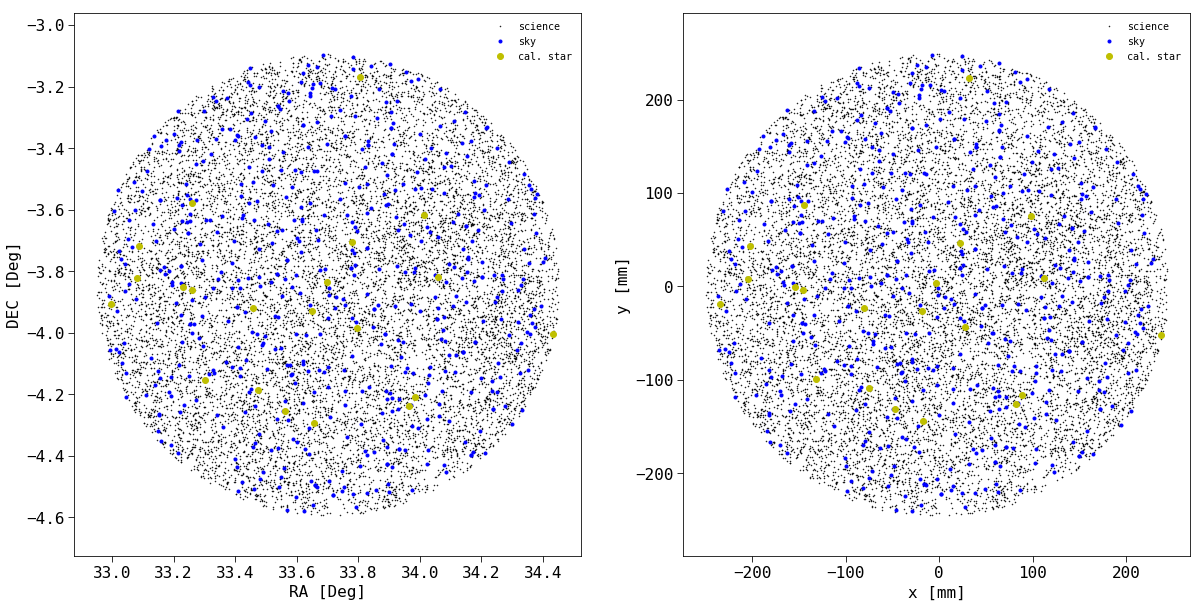

In [16]:
# plot targets on sky
f = plt.figure(figsize=[20,10])
plt.subplot(121)
plt.plot(np.array(ra)[ii_sci],np.array(dec)[ii_sci],'.', ms=1, label='science')
plt.plot(np.array(ra)[ii_sky],np.array(dec)[ii_sky],'b.' , label='sky')
plt.plot(np.array(ra)[ii_cal],np.array(dec)[ii_cal],'yo' , label='cal. star')
plt.axis('equal')
l = plt.legend()
l.draw_frame(False)
plt.xlabel("RA [Deg]")
plt.ylabel("DEC [Deg]")

plt.subplot(122)

txx = np.array( [t[0] for tid, t in targets.iteritems()] )
tyy = np.array( [t[1] for tid, t in targets.iteritems()] )


#for tc in unique(tclasses):

_ii_sci = map( lambda x : x.startswith('sci') , tclasses )
_ii_sky = map( lambda x : x.startswith('sky') , tclasses )
_ii_cal = map( lambda x : x.startswith('cal') , tclasses )
plt.plot(txx[_ii_sci],tyy[_ii_sci],'.', ms=1, label='science')
plt.plot(txx[_ii_sky],tyy[_ii_sky],'b.' , label='sky')
plt.plot(txx[_ii_cal],tyy[_ii_cal],'yo' , label='cal. star')

#plt.plot(txx[ii_sky],tyy[ii_sky],'b.' , label='sky')
#plt.plot(txx[ii_cal],tyy[ii_cal],'yo' , label='cal. star')


plt.axis('equal')
l = plt.legend()
l.draw_frame(False)
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")

# Collisions

Found  6144 collision pairs.
6144


(-15, 15)

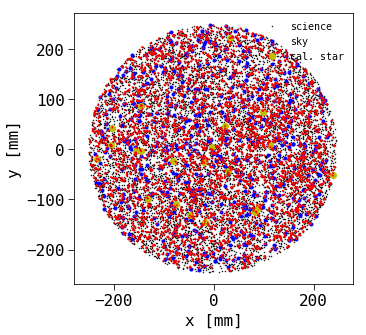

In [17]:

# find collision pairs


from scipy.spatial.distance import cdist
fiber_collision_radius = 1.


f = plt.figure(figsize=[5,5])
plt.subplot()
txx = np.array( [t[0] for tid, t in targets.iteritems()] )
tyy = np.array( [t[1] for tid, t in targets.iteritems()] )

_ii_sci = map( lambda x : x.startswith('sci') , tclasses )
_ii_sky = map( lambda x : x.startswith('sky') , tclasses )
_ii_cal = map( lambda x : x.startswith('cal') , tclasses )


plt.plot(txx[_ii_sci],tyy[_ii_sci],'.', ms=1, label='science')
plt.plot(txx[_ii_sky],tyy[_ii_sky],'b.' , label='sky')
plt.plot(txx[_ii_cal],tyy[_ii_cal],'yo' , label='cal. star')


N = len(ID)
points = zip(txx,tyy)
Y = cdist( points[:N], points[:N] )

# any target separation that is smaller than 2 x the collision radius will be flagged a s collision
cc = Y <= (fiber_collision_radius*2.) 
ncoll = int( (np.sum(cc.flatten()) - N)/2. )

print ("Found  {:d} collision pairs.".format( ncoll  ))

# identify collision pairs
collision_pairs = []
# array of indices
ii = np.arange(N)
for i in range(cc.shape[0]):
    x1,y1 =  txx[i], tyy[i]
    # only iterate over the indeces that are colliding and the upper diagonal in the collision matrix
    jj = ii[ cc[i,:] * ii > i ] 
    for j in jj: 
        if cc[i,j]:
            x2,y2 =  txx[j], tyy[j]
            collision_pairs.append([(ID[i],x1,y1),(ID[j],x2,y2)])
            
            
            
for cp in collision_pairs:
    plt.plot([cp[0][1],cp[1][1]],[cp[0][2],cp[1][2]],'r-')
    #plt.plot(txx[ii_cal],tyy[ii_cal],'yo' , label='cal. star')

print len(collision_pairs)

plt.axis('equal')
l = plt.legend()
l.draw_frame(False)
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.xlim([-15,15])

# Invert visibilities

In [18]:
# Compute a few statistics:
# Number of rachable targets by type and
# number of cobras that can observe any target.
def invert_vis(visibilities):
    """
    Invert visibility map, i.e. for each cobra list the observable targets
    """
    ivisibilities = {}

    cnt = 0
    for v in visibilities:
        t = v
        cc = visibilities[v]

        for c in cc:
            if ivisibilities.has_key(c):
                ivisibilities[c].append(v)
            else:
                ivisibilities[c] = [v]

    return ivisibilities

ivisibilities = invert_vis(visibilities)           

In [19]:
nsci_observable = 0
ncal_observable = 0
nsky_observable = 0

for tid,v in visibilities.iteritems():
    if len(v) > 0:
        if class_dict[tid][:3] == 'cal':
            ncal_observable += 1
        elif class_dict[tid][:3] == 'sky':
            nsky_observable += 1
        elif class_dict[tid][:3] == 'sci':
            nsci_observable += 1
        #break
            
            
print("{} targets positions in total.".format(sum(ii_sci) ))
print("{} cal. targets in total.".format(sum(ii_cal) ))
print("{} sky positions in total.".format(sum(ii_sky) ))
print("{} cobras have at least one target in reach.".format(len(ivisibilities)))
print("{} science targets\n{} calibration targets, \
and \n{} sky positions are in reach of at least one cobra.".format(nsci_observable, ncal_observable, nsky_observable))  

12556 targets positions in total.
21 cal. targets in total.
558 sky positions in total.
2366 cobras have at least one target in reach.
8116 science targets
13 calibration targets, and 
367 sky positions are in reach of at least one cobra.


# run the ETS solver

In [103]:
def fil(xx,bb):
    """
    Takes a list of objects and a boolean list of same length.
    Retruns a list with all thos object for which the boolean
    input list had a True.
    """
    new = []
    for x,b in zip(xx,bb):
        if b: new.append(x)
    return new

In [65]:
import numpy as np
import time
    
ALGORITHM = "new"
ALGORITHM = "draining"
ALGORITHM = "naive"
ALGORITHM = "draining_closest"

ALL_ALGORITHM = ["new", "draining", "naive", "draining_closest"]

for ALGORITHM in ALL_ALGORITHM:
    print("ALGORITHM {}".format(ALGORITHM))
    NVISISTS = 10
    ii = np.full_like(ID, True, dtype=bool)

    # set priorities 
    priorities2 = np.array(priorities)
    priorities2[ii_sci] = 5
    priorities2[~ii_sci] = 1
    priorities2 = priorities2.tolist()

    with open("ets_results_{}.txt".format(ALGORITHM), 'w') as f:
        s = "# algorithm: {}\n".format(ALGORITHM)
        s += "# total number of vistis: {}\n".format(NVISISTS)

        s += "# total number of observable science targets: {}\n".format(nsci_observable)
        s += "# total number of observable cal. targets: {}\n".format(ncal_observable)
        s += "# total number of observable sky positions: {}\n".format(nsky_observable)
        s += "{:3s} {:5s} {:5s} {:5s} {:5s}\n".format("V", "nsci", "ncal", "nsky", "nsci_total")
        f.write(s)

        for v in range(NVISISTS):
            s= ""

            print("Visit {}".format(v))
            print(" Number of remaining targets to observe: {}".format(sum(ii)))

            #print(" Number of remaining cal. targets to observe: {}".format( sum( np.array(types)[ii] == "cal" ) ))
            #print(" Number of remaining sky targets to observe: {}".format( sum( np.array(types)[ii] == "sky" ) ))

            start_time = time.time()
            # perform target assignment using the "draining" algorithm, and return the list
            # of assigned targets and which cobras were used to observe them.
            #res = pyETS.getObs(fil(ets_target_pos,ii),fil(exp_times,ii),fil(priorities,ii),ets_cobras,"draining_closest")
            res = pyETS.getObs(ets_target_pos,exp_times,priorities2,ets_cobras,ALGORITHM)
            time_to_build = time.time() - start_time
            pp(" Time to solve: {:.4e} s".format(time_to_build))



            # figure which out of all potential science targets have been observed
            # and mark them as observed
            for r in res:
                if types[r] == 'sci':
                    priorities2[r] = 15
                    ii[r] = False

            # compute some statistics
            nsci_observed = sum(np.array(types)[ res.keys() ] == 'sci')
            ncal_observed = sum(np.array(types)[ res.keys() ] == 'cal')
            nsky_observed = sum(np.array(types)[ res.keys() ] == 'sky')
            print(" Observed {} science targets, {} calibration targets and {} sky positions"\
                  .format(nsci_observed, ncal_observed, nsky_observed))
            N = len( res.items() )
            #print(" Observed {} targets.".format(N))
            nsci_observed_total = sum(ii_sci * ~ii)
            print(" Observed {} science targets in total.".format(nsci_observed_total))
            print("")

            s += "{:3d} {:5d} {:5d} {:5d} {:5d}\n".format(v, nsci_observed, ncal_observed, nsky_observed, nsci_observed_total)
            f.write(s)

#np.any( np.array(types)[ res.keys() ] == 'cal' )

ALGORITHM new
Visit 0
 Number of remaining targets to observe: 13135
 Time to solve: 3.3713e-02 s
 Observed 2010 science targets, 12 calibration targets and 329 sky positions
 Observed 2010 science targets in total.

Visit 1
 Number of remaining targets to observe: 11125
 Time to solve: 2.8042e-02 s
 Observed 2006 science targets, 12 calibration targets and 329 sky positions
 Observed 3860 science targets in total.

Visit 2
 Number of remaining targets to observe: 9275
 Time to solve: 2.7457e-02 s
 Observed 2010 science targets, 12 calibration targets and 329 sky positions
 Observed 5391 science targets in total.

Visit 3
 Number of remaining targets to observe: 7744
 Time to solve: 3.1763e-02 s
 Observed 2007 science targets, 12 calibration targets and 329 sky positions
 Observed 6359 science targets in total.

Visit 4
 Number of remaining targets to observe: 6776
 Time to solve: 2.4314e-02 s
 Observed 2010 science targets, 12 calibration targets and 329 sky positions
 Observed 6849 s

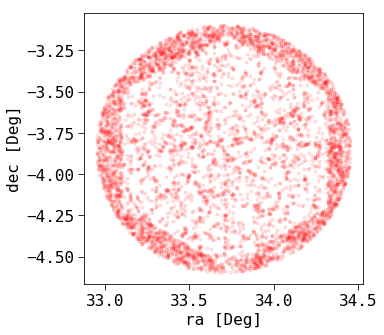

In [66]:
# Plot unobserved targets
from numpy import array
from matplotlib import pyplot as plt
% matplotlib inline
f = plt.figure(figsize=[5,5])

#plt.plot(fil(ra,~ii), fil(dec,~ii), '.', color='k')
plt.plot(fil(ra,ii), fil(dec,ii), '.', color='r', alpha=0.1)

plt.ylabel('dec [Deg]')
plt.xlabel('ra [Deg]')
#plt.axis("equal")

#plt.xlim([33.25,34.74])
#plt.ylim([-5.25,-3.75])

# Execute netflow

In [20]:
# Define the cost function
from numpy import inf

cost_dict = {}
# For each target class we define the cost of non-observation
# and non-completion as a two-tuple. The cost of non-completion 
# is typically larger as partial completion of objects should be avoided.
cost_dict['sci_P1'] = (1000.,1e9)
cost_dict['sci_P2'] = (100.,1e9)
cost_dict['sci_P3'] = (10.,1e9)

# For the calibration objects we only define the cost
# of non-observation as calibration targets only *need* to be visited once.
# Note: The can of course be visited many times. But
# for the calibration objects the real constraint is to have 
# at least N out of M observed in each exposure.
# There is no requirement to revisit a specific calibration target.
cost_dict['cal_P1'] = 10000.
cost_dict['sky_P1'] = 10000.

# Here we add higher cost to later visits. Ther should be one entry per visit.
cost_dict['visits'] = [i*10. for i in np.arange(10)]

# Here we discourage large cobra moves. The example here is a simple
# linear function cost = A * move_distance 
# where the parameter A controls how quickly the cost increases as funciton of distance.
#A = 250.
A = 0.
cost_dict['cobra_move'] = lambda d : d*A  



# Here we define how at least many objects out of each class we want observed.
supply_dict = {}
# By setting science object to inf, we say we want them all.
supply_dict['sci_P1'] = inf
supply_dict['sci_P2'] = inf
supply_dict['sci_P3'] = inf

# need one calibration star per exposure
supply_dict['cal_P1'] = 16 # inf = try to get as amny as  possible
# need one sky positions per exposure
supply_dict['sky_P1'] = 322 # inf = try to get as amny as  possible


# need one calibration star per exposure
supply_dict['cal_P1'] = 1# 12
# need one sky positions per exposure
supply_dict['sky_P1'] = 1# 329




In [52]:
# Build the survey plan graph.

from numpy import inf
from pfs_netflow.survey_plan import buildSurveyPlan
from pfs_netflow.plotting import plotSurveyPlan

NVISITS = 2
COBRAS = []


# good minimal example
RMAX = 10.
CENTER = [0.,0.]
name="minimal"

# intermediate example
RMAX = 60.
CENTER = [0.,0.]
name="intermediate"




# good minimal example
RMAX = 100.
CENTER = [0.,0.]
name="minimal"



# intermediate example
RMAX = 150.
CENTER = [-5.,90.]
name="intermediate"


# smaller intermediate example
RMAX = 75.
CENTER = [-0.,0.]
name="small"

# good minimal example
RMAX = 25.
CENTER = [-5.,90.]
name="minimal"

# intermediate example
RMAX = 150.
CENTER = [0.,0.]
name="intermediate"

# do them all!
RMAX = 300.
CENTER = [-0.,0.]
name="all"

# good very minimal example
RMAX = 25.
CENTER = [-0.,0.]
name="tiny"



# good very minimal example
RMAX = 10.
CENTER = [-0.,0.]
name="tinytiny"




print("Creating graph ...")
g = buildSurveyPlan(cobras, targets, nreqvisits, visibilities, class_dict, cost_dict, supply_dict, NVISITS, \
                    RMAX, CENTER, COBRAS = COBRAS)
print("Done.")

for c in g.sciTargetClasses:
    
    nsci = 0
    nsci_reachable = 0
    for t in g.sciTargetClasses[c].targets.itervalues():
        if t.outarcs != []:
            nsci += 1
            nsci_reachable += 1
        
    print("Number of targets in {} is {}.".format(c, nsci ) )
    print("Number of observable targets in {} is {}.".format(c, nsci_reachable ) )
    

ncal = 0
ncal_reachable = 0
for t in g.calTargetClasses['TClass_cal_P1_v0'].targets.itervalues():
    if t.outarcs != []:
        ncal += 1
        ncal_reachable += 1
print("Number of calibration stars: {}".format(ncal) )
print("Number of observable calibration stars: {}".format( ncal_reachable )) 
            

nsky = 0
nsky_reachable = 0
for t in g.calTargetClasses['TClass_sky_P1_v0'].targets.itervalues():
    if t. outarcs != []:
        nsky += 1
        nsky_reachable += 1
print("Number of sky positions: {}".format(nsky) )
print("Number of observable sky positions: {}".format(nsky_reachable) )

#if RMAX == 10. and False:
#    plotSurveyPlan(g)
    



Creating graph ...
buildSurveyPlan 
Done.
Number of targets in TClass_sci_P1 is 36.
Number of observable targets in TClass_sci_P1 is 36.
Number of calibration stars: 1
Number of observable calibration stars: 1
Number of sky positions: 1
Number of observable sky positions: 1


In [53]:
# build the LP problem
from pfs_netflow.lp import buildLPProblem, computeStats, solve
from pulp import LpStatus, value
import time


def setflows(g,flows):
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])


    
NCobras = len(g.cobras)
NSciTargets = len(g.sciTargets)
NCalTargets = len(g.calTargets)

maxSeconds = 600.

summary = ""
summary += pp("NVISITS = {}".format(NVISITS))
summary += pp("Searching optimal strategy to observe in ")
summary += pp(" {} visits".format(NVISITS))
summary += pp(" {} science targets".format(NSciTargets))
summary += pp(" {} calib. targets".format(NCalTargets/NVISITS))
summary += pp(" {} cobras".format(NCobras))
summary += pp("Will stop in any case after {} s.".format(maxSeconds))


summary += pp("num nodes: {}".format(len(g.nodes)))
summary += pp("num edges: {}".format(len(g.arcs)))

#visualizeSurveyPlan(g)

summary += pp("Building LP problem ...")
start_time = time.time()
prob, flows, cost = buildLPProblem(g, cat='Integer')
#prob, flows, cost = buildLPProblem(g, cat='Continuous')
time_to_build = time.time() - start_time
summary += pp("Time to build model: {:.4e} s".format(time_to_build))

__ = prob.writeMPS("pfi_cosmo_{}_{}_visits_rand_nreq.mps".format(name,NVISITS), rename=1)

NVISITS = 2
Searching optimal strategy to observe in 
 2 visits
 36 science targets
 3 calib. targets
 6 cobras
Will stop in any case after 600.0 s.
num nodes: 138
num edges: 251
Building LP problem ...
Building cost equation ...
 Time to completion: 0.02 s
Time to build model: 2.5800e-02 s


In [54]:
import pulp

def compute_collision_flow_pairs(collision_pairs):
    """
     Identifiy which flow variables correspond to which collision pairs.

     This is not a nice piece of code, mostly because we need to treat science and
     calibrations targets differently
     What we do:
     Loop over all collision pairs (science - science, science - cal, cal - cal)
      then for each visit
       look if they are actually part of the graph (in case we are dealing with a subregaion of the focal plane only we might ignore them)
       identify the input flow arc (ther can be only one) for each of the two targets in the pair
       add the flow pairs to a list
     loop over all flow pairs and add a constraint equation
    """ 
    flow_pairs = []

    for cp in collision_pairs:
        for visit in g.visits:
            tid1 = cp[0][0]
            tid2 = cp[1][0]

            tvid1 = "T_{}_v{}".format(cp[0][0],visit)
            tvid2 = "T_{}_v{}".format(cp[1][0],visit)

            # science targets have targetVisit nodes
            # calibrations targets do not (there ais a doublicate for each visits)
            if g.calTargets.has_key(tvid1):
                f1id = g.calTargets[tvid1].inarcs[0].id
            elif g.targetVisits.has_key(tvid1):
                f1id = g.targetVisits[tvid1].inarcs[0].id
            else:
                continue # this target is not part of the problem, probably did not survive RMAX cut

            if g.calTargets.has_key(tvid2):
                f2id = g.calTargets[tvid2].inarcs[0].id
            elif g.targetVisits.has_key(tvid2):
                f2id = g.targetVisits[tvid2].inarcs[0].id
            else:
                continue # this target is not part of the problem, probably did not survive RMAX cut


            flow_pairs.append([f1id, f2id])
    return flow_pairs
  
ENABLE_COLLISION_AVOIDANCE = True
if ENABLE_COLLISION_AVOIDANCE:
    flow_pairs = compute_collision_flow_pairs(collision_pairs)
    print("Adding {} collision avoidance constraints.".format(len(flow_pairs)))              
    for fp in flow_pairs:
        prob += pulp.lpSum( [ flows[ fp[0] ], flows[ fp[1] ] ] ) <= 1.

__ = prob.writeMPS("pfi_cosmo_{}_{}_visits_rand_nreq_colldetect.mps".format(name,NVISITS), rename=1)

Adding 56 collision avoidance constraints.


In [55]:
# solve it!
maxSeconds=2400.

random.seed(42)

# Solve problem!
summary += pp("Solving LP problem ...")
start_time = time.time()


#status = solve(prob, maxSeconds=maxSeconds)
status = solve(prob, solver="GUROBI")


time_to_solve = time.time() - start_time
summary += pp("Solve status is [{}].".format( LpStatus[status] ))
summary += pp("Time to solve: {:.4e} s".format(time_to_solve))

stats = computeStats(g, flows, cost)

summary += pp("{} = {}".format('Value of cost function',value(stats.cost) ) )
summary += pp("[{}] out of {} science targets get observed.".format(int(stats.NSciObs),NSciTargets))
summary += pp("For {} out of these all required exposures got allocated.".format(stats.NSciComplete))
summary += pp("{} targets get sent down the overflow arc.".format(stats.Noverflow))
summary += pp("{} out of {} cobras observed a target in one or more exposures.".format(stats.Ncobras_used, NCobras ))
summary += pp("{} cobras observed a target in all exposures.".format(stats.Ncobras_fully_used))

setflows(g,flows)

Solving LP problem ...
Optimize a model with 188 rows, 252 columns and 639 nonzeros
Variable types: 1 continuous, 251 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+06]
  RHS range        [1e+00, 4e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.82e+11
Presolve removed 133 rows and 112 columns
Presolve time: 0.00s
Presolved: 55 rows, 140 columns, 250 nonzeros
Found heuristic solution: objective 1.660000e+11
Variable types: 0 continuous, 140 integer (110 binary)

Root relaxation: objective 3.054000e+04, 55 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 30540.0000    0    3 1.6600e+11 30540.0000   100%     -    0s
H    0     0                    3.000029

In [56]:
# test if really no colliding targets were observed
# This needs to be added to the survey plan and buildLPProblem methods.
#
import pulp
from pulp import value


flow_pairs = compute_collision_flow_pairs(collision_pairs)
 
NCOLL = 0
for fp in flow_pairs:
    
    if value( flows[ fp[0] ] ) > 0. and value( flows[ fp[1] ] ) > 0.:
        #print("{} {} in collision".format(fp[0],fp[1]))
        NCOLL += 1
                             
print("Detected {} collisions".format(NCOLL))

Detected 0 collisions


In [57]:
value( flows[ fp[1] ] )

0.0

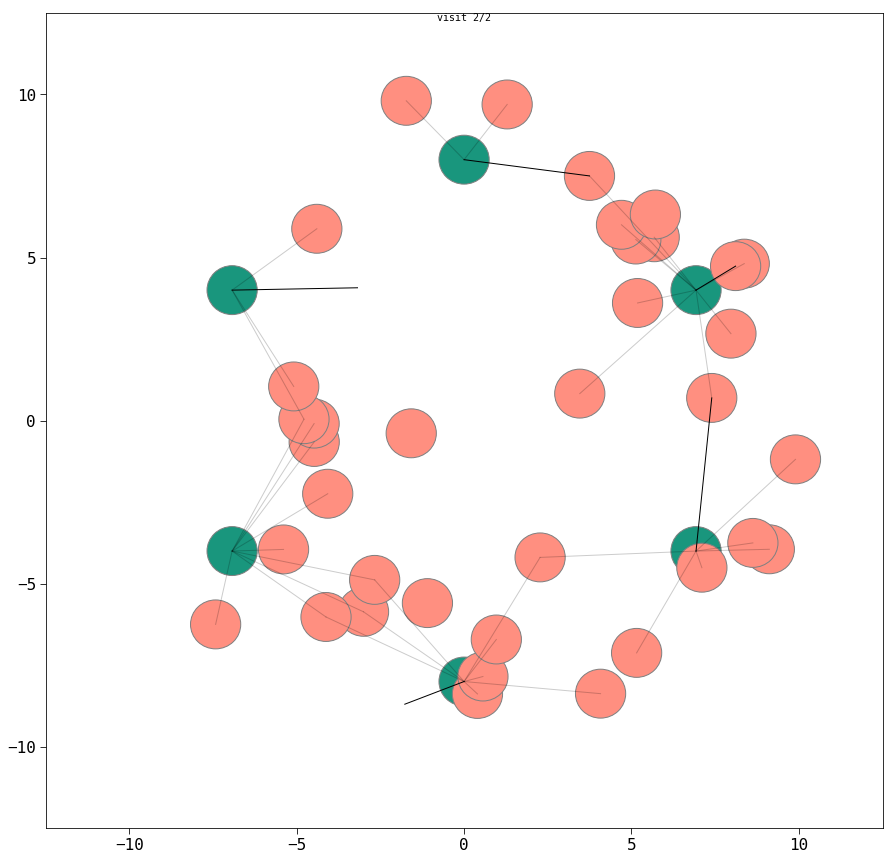

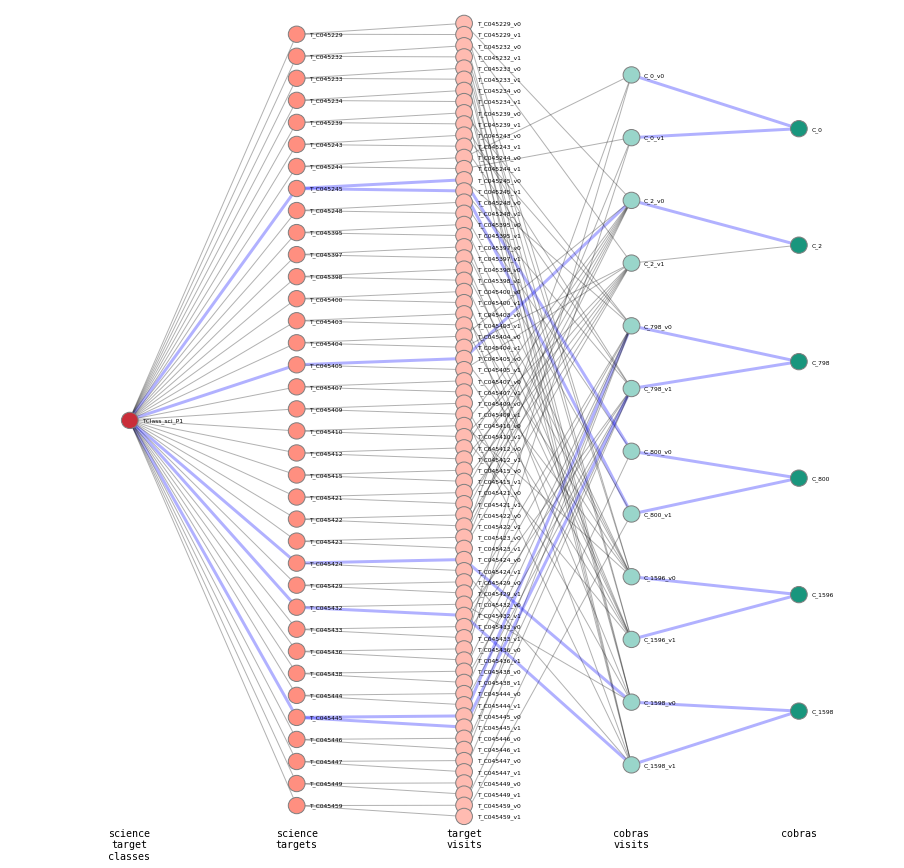

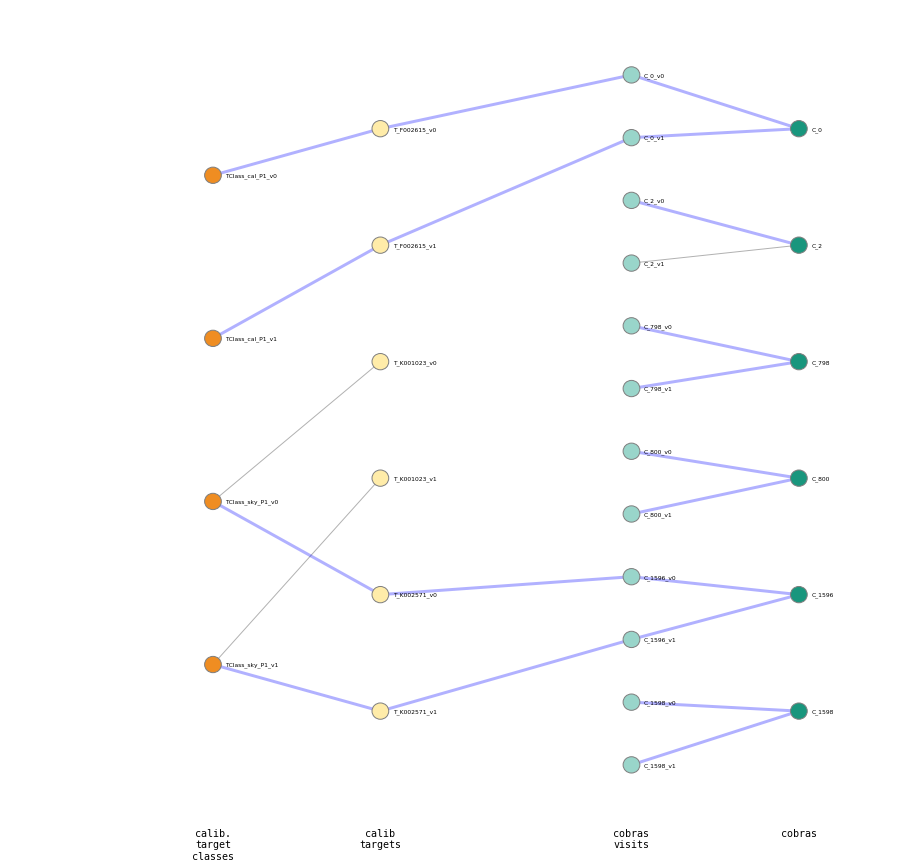

In [60]:
from pfs_netflow.plotting import plotFocalPlane
def setflows(g,flows):
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])
            
if True:
    from pfs_netflow.plotting import plotFocalPlane

    plotFocalPlane(g, visit=1, W=25)
    plotSurveyPlan(g)

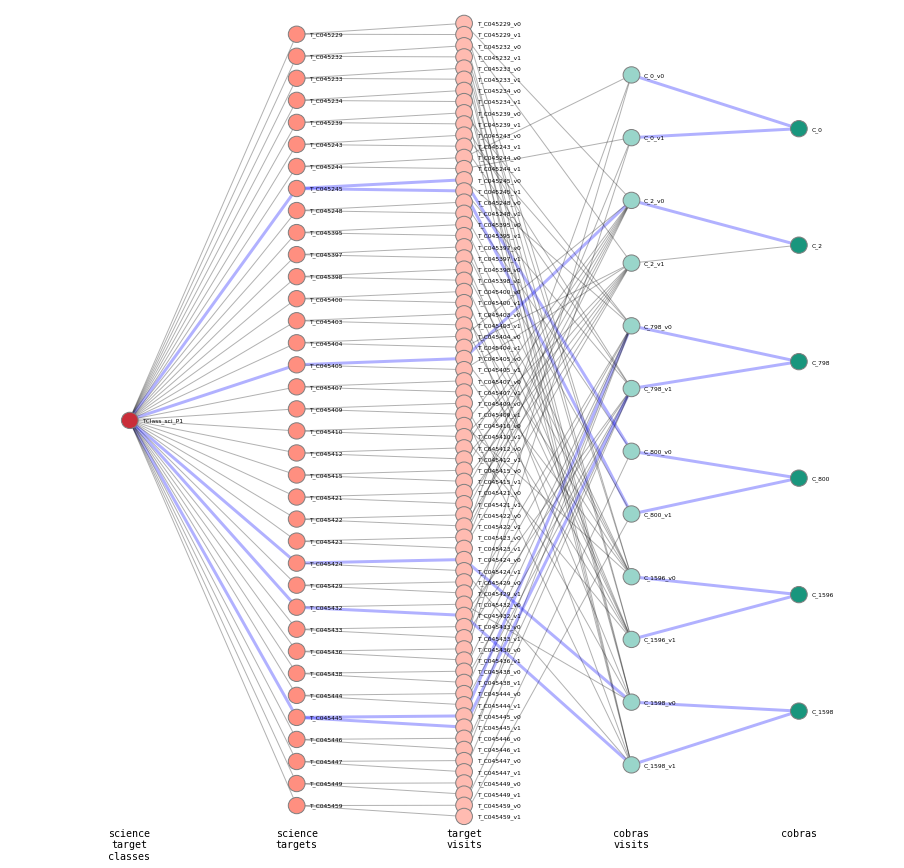

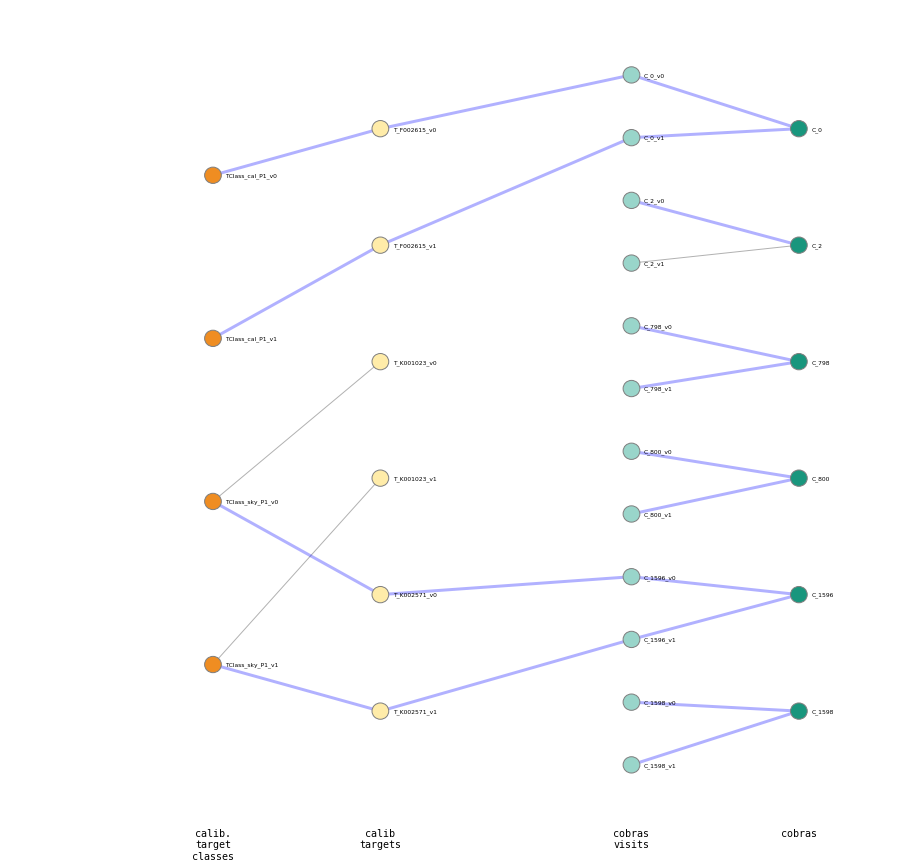

In [59]:
plotSurveyPlan(g)

# prepare Cobra/Target pairs to run trajectory collision detection

In [41]:

visit = 0
 
# initialize assigment list with Null
# as required by the collision simulator code.
assignments = OrderedDict()
for c in g.cobras.itervalues():
    assignments[c.id] = 'Null'

# Now find which cobras have been assigned to which targets. 
# Loop over all targetVisit to CobraVisit arcs.Filter for those that correspond to the current visit.
for a in filter(lambda x : x.visit == visit, g.targetVisitToCobraVisitArcs.itervalues()):
    
    if a.flow > 0.:
        t = a.startnode.target
        c = a.endnode.cobra 
        assignments[c.id] = t.id
        
for cid,tid in assignments.iteritems():
    print("{:6s} observes {:10s}".format(cid, tid))


C_0    observes Null      
C_1    observes T_C045427 
C_2    observes Null      
C_3    observes Null      
C_4    observes Null      
C_5    observes T_C045220 
C_6    observes T_C045340 
C_7    observes T_C045345 
C_8    observes Null      
C_9    observes Null      
C_10   observes T_C045202 
C_11   observes Null      
C_12   observes Null      
C_13   observes Null      
C_14   observes T_C045183 
C_15   observes T_C045158 
C_16   observes Null      
C_17   observes Null      
C_18   observes Null      
C_19   observes Null      
C_20   observes T_C045100 
C_21   observes T_C044936 
C_22   observes Null      
C_23   observes T_C044933 
C_24   observes Null      
C_25   observes T_C045011 
C_26   observes T_C044992 
C_27   observes Null      
C_28   observes Null      
C_29   observes Null      
C_30   observes T_C044723 
C_31   observes T_C044879 
C_32   observes Null      
C_33   observes T_C044841 
C_34   observes Null      
C_35   observes T_C044696 
C_36   observes Null      
C

In [42]:
# feed to collision code
import numpy as np
import time as time

import sys
sys.path.append("/Users/mxhf/work/MPE/pfs/src/ics_cobraOps/python")

import ics.cobraOps.plotUtils as plotUtils
import ics.cobraOps.targetUtils as targetUtils

from ics.cobraOps.Bench import Bench
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.DistanceTargetSelector import DistanceTargetSelector
from ics.cobraOps.RandomTargetSelector import RandomTargetSelector

# Create the bench instanceroduct)
#bench = Bench(layout="full", calibrationProduct=calibrationP
cpos = [ [ complex(g.cobras[cid].x , g.cobras[cid].y) ] for cid in assignments]
bench = Bench(cobraCenters=np.array( cpos ))

print("Number of cobras:", bench.cobras.nCobras)

ValueError: too many values to unpack

In [ ]:

# Calculate the total number of targets based on the bench properties
    medianPatrolAreaRadius = np.median(bench.cobras.rMax)

    
    nTargets = int(np.ceil(density * (bench.radius / medianPatrolAreaRadius) ** 2))
    
    # Calculate the uniformly distributed target positions
    ang = 2 * np.pi * np.random.random(nTargets)
    radius = bench.radius * np.sqrt(np.random.random(nTargets))
    targetPositions = bench.center + radius * np.exp(1j * ang)
    
    return TargetGroup(targetPositions)

In [59]:
# Generate the targets
targets = targetUtils.generateRandomTargets(targetDensity, bench)
print("Number of simulated targets:", targets.nTargets)

# Select the targets
selector = DistanceTargetSelector(bench, targets)
selector.run()
selectedTargets = selector.getSelectedTargets()

# Simulate an observation
start = time.time()
simulator = CollisionSimulator(bench, selectedTargets)
simulator.run()
print("Number of cobras involved in collisions:", simulator.nCollisions)
print("Number of cobras unaffected by end collisions: ", simulator.nCollisions - simulator.nEndPointCollisions)
print("Total simulation time (s):", time.time() - start)

{<pfs_netflow.datamodel.Cobra at 0x107c6e490>: <pfs_netflow.datamodel.SciTarget at 0x108dcab10>,
 <pfs_netflow.datamodel.Cobra at 0x107c6e910>: 'Null',
 <pfs_netflow.datamodel.Cobra at 0x121ae1590>: <pfs_netflow.datamodel.SciTarget at 0x123480f90>,
 <pfs_netflow.datamodel.Cobra at 0x121ae18d0>: 'Null',
 <pfs_netflow.datamodel.Cobra at 0x122c78710>: <pfs_netflow.datamodel.SciTarget at 0x1233cc090>,
 <pfs_netflow.datamodel.Cobra at 0x122c78c50>: <pfs_netflow.datamodel.SciTarget at 0x16f6b2990>,
 <pfs_netflow.datamodel.Cobra at 0x1234f6890>: <pfs_netflow.datamodel.SciTarget at 0x1234d9610>,
 <pfs_netflow.datamodel.Cobra at 0x123505350>: <pfs_netflow.datamodel.SciTarget at 0x123444a90>,
 <pfs_netflow.datamodel.Cobra at 0x16f427810>: <pfs_netflow.datamodel.SciTarget at 0x12349e110>,
 <pfs_netflow.datamodel.Cobra at 0x16f427fd0>: <pfs_netflow.datamodel.SciTarget at 0x108dbd3d0>,
 <pfs_netflow.datamodel.Cobra at 0x16f4c7310>: <pfs_netflow.datamodel.SciTarget at 0x16e101e10>,
 <pfs_netflow.dat

# Statistics on cobra motion

In [ ]:

# array of all distances for all possible target/cobra pairs
dd =  np.array( [ a.d for a in g.targetVisitToCobraVisitArcs.itervalues()] )
# array of flows for all possible target/cobra pairs
ff =  np.array( [ value(flows[a.id]) for a in g.targetVisitToCobraVisitArcs.itervalues()] )

# caclulate mean cobra move distance
ii = ff > 0.
mn_movedist = np.mean( dd[ii] )
min_movedist = np.min( dd[ii] )
max_movedist = np.max( dd[ii] )
std_movedist = np.std( dd[ii] )

print("mn_movedist =  {:.3f}mm".format(mn_movedist) )
print("min_movedist = {:.3f}mm".format(min_movedist) )
print("max_movedist = {:.3f}mm".format(max_movedist) )
print("std_movedist = {:.3f}mm".format(std_movedist) )


cm = np.sum([ a.cost * value(flows[a.id]) for a in g.targetVisitToCobraVisitArcs.itervalues() ])

print("cost from moves = {}".format(cm) )


plt.hist( dd[ii] )
plt.xlabel("d[mm]")
plt.ylabel("N")

# Performace evaluations observed targets vs. number of visits

In [ ]:
nsci_observed_total = 0


with open("nwf_results_nvisits{}_early_obs2.txt".format(NVISITS), 'w') as f:
    s  = "# algorithm: {}\n".format("netflow")
    s += "# total number of vistis: {}\n".format(NVISISTS)

    s += "# total number of observable science targets: {}\n".format(nsci_observable)
    s += "# total number of observable cal. targets: {}\n".format(ncal_observable)
    s += "# total number of observable sky positions: {}\n".format(nsky_observable)
    s += "{:3s} {:5s} {:5s} {:5s} {:5s}\n".format("V", "nsci", "ncal", "nsky", "nsci_total")
    f.write(s)

    for visit in g.visits:
        print("Visit {}".format(visit))
        nsci = 0
        ncal = 0
        nsky = 0
        for a in g.arcs.itervalues():
            n1,n2 = a.startnode,a.endnode

            if a.flow > 0.:
                #print n1,n2, a.flow, n2.visit
                #print type(n2) == dm.CobraVisit , n2.visit == visit , type(n1) == dm.TargetVisit
                #break
                if type(n2) == dm.CobraVisit and n2.visit == visit and type(n1) == dm.TargetVisit:
                        nsci += 1
                        nsci_observed_total += 1
                if type(n2) == dm.CobraVisit and n2.visit == visit and type(n1) == dm.CalTarget:
                        try:
                            if class_dict[ n1.id[2:-3] ][:3] == "sky":
                                nsky += 1

                            else:
                                ncal += 1 
                        except:
                            pass

        s = "{:3d} {:5d} {:5d} {:5d} {:5d}\n".format(visit, nsci, ncal, nsky, nsci_observed_total)
        f.write(s)
        
        print(" Observed {} science targets, {} calibration targets and {} sky positions.".format(nsci, ncal, nsky))
        print(" Observed {} science targets in total.".format(nsci_observed_total))
        #print("")


In [ ]:
g.targetToTargetVisitArcs

value( flows['T_C000996->T_C000996_v0'.replace("->","=")] )

In [ ]:
from pfs_netflow.plotting import plotFocalPlane
def setflows(g,flows):
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])
            
if False:
    from pfs_netflow.plotting import plotFocalPlane

    plotFocalPlane(g, visit=1, W=20)
    plotSurveyPlan(g)

In [ ]:
nsci = sum( [class_dict[t][:3] == "sci" for t in targets] )
ncal = sum( [class_dict[t][:3] == "cal" for t in targets] )
nsky = sum( [class_dict[t][:3] == "sky" for t in targets] )

sum( [class_dict[t][:3] == "cal" for t in targets] )


print("{} targets positions in total.".format( nsci ))
print("{} cal. targets in total.".format( ncal ))
print("{} sky positions in total.".format( nsky ))


# performance comparison ETS vs. netflow

In [43]:
from astropy.io import ascii

nwf_results_nvisits = {}
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
nwf_results_nvisits[10] = ascii.read("nwf_results_nvisits10_early_obs1.txt")
#nwf_results_nvisits[9] = ascii.read("nwf_results_nvisits9.txt")
#nwf_results_nvisits[8] = ascii.read("nwf_results_nvisits8.txt")
#nwf_results_nvisits[7] = ascii.read("nwf_results_nvisits7.txt")
#nwf_results_nvisits[6] = ascii.read("nwf_results_nvisits6.txt")
#nwf_results_nvisits[5] = ascii.read("nwf_results_nvisits5.txt")
#nwf_results_nvisits[4] = ascii.read("nwf_results_nvisits4.txt")
#nwf_results_nvisits[3] = ascii.read("nwf_results_nvisits3.txt")
#nwf_results_nvisits[2] = ascii.read("nwf_results_nvisits2.txt")

ets_results = {}
ets_results["draining_closest"] = ascii.read("ets_results_draining_closest.txt")
ets_results["draining"] = ascii.read("ets_results_draining.txt")
ets_results["naive"] = ascii.read("ets_results_naive.txt")
ets_results["new"] = ascii.read("ets_results_new.txt")

#ascii.read("ets_results_draining_closest.txt",format

f = plt.figure(figsize=[8,8])

for alg in ets_results:
    plt.plot(ets_results[alg]['V']+1, ets_results[alg]['nsci_total'],'o-', label=alg)

#for nvisits in nwf_results_nvisits:
#    plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label=alg, color='grey', ms=8)

nvisits = 10
plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label="netflow", color='grey', ms=8)

l = plt.legend()
l.draw_frame(False)

plt.axhline(nsci_observable,ls=":",c='k')
plt.text(1,nsci_observable+50,"max # science targets observable".format(nsci_observable),ha='left',va='bottom')
plt.ylabel("# science targets observed")
plt.xlabel("visit")
plt.ylim([500,8200])

IOError: [Errno 2] No such file or directory: 'nwf_results_nvisits10_early_obs1.txt'

# New & auxiliary stuff

In [204]:
if False:
    # test output for other solvers
    # build problem save to MPS
    import time


    summary += pp("Building LP problem ...")
    start_time = time.time()
    #prob, flows, cost = buildLPProblem(g, cat='Integer')
    prob, flows, cost = buildLPProblem(g, cat='Continuous')
    time_to_build = time.time() - start_time
    summary += pp("Time to build model: {:.4e} s".format(time_to_build))

    prob.writeMPS("pfi_cosmo_{}_{}_visits_rand_nreq.mps".format(name,NVISITS), rename=1)

Building LP problem ...
Building cost equation ...
 Time to completion: 7.89 s
Time to build model: 7.9381e+00 s


In [ ]:
RSEP = 5.

if RSEP > 0.:
    print("Finding collision pairs ...")
    tt = np.array( [t for t in g.targets.itervalues()] )
    tt_xy = [ (g.targets[t].x,g.targets[t].y) for t in g.targets]

    N = len(tt)

    from scipy.spatial import distance
    # calculat collisions from all pairwise separations
    colls = distance.cdist(tt_xy, tt_xy, 'euclidean') < RSEP
    # set lower diagonal to False, if we know that A collides with B already
    # then we don't need to take into account that B collides with A
    colls[ np.tril_indices(N) ] = False 

    coll_pairs = []
    for i,t1 in enumerate(tt):
        for t2 in tt[ colls[i] ].tolist():
            coll_pairs.append([t1,t2])
            #print t1.id,t2.id

    print( "Found {} collision pairs.".format(len( coll_pairs )) )

    #for tid,t in tt:
    #    prob += pulp.lpSum( [ flows['{}={}'.format(a.startnode.id,a.endnode.id)] for a in t.outarcs]) <= 1
    
    

In [ ]:
i = 0

t1,t2 = coll_pairs[i]

print type(t1) == SciTarget
print type(t1) == CalTarget

t2.outarcs

In [ ]:
# Sanity check, make sure all flows are integer:
allflows = []
for a in g.arcs.itervalues():
    k = '{}={}'.format(a.startnode.id,a.endnode.id)
    if flows.has_key(k):
        allflows.append(value(flows[k]))

print("All flows are: integer {}".format(all( unique(allflows)%1 == 0 )))


In [ ]:
if True:
    # plot solution
    for a in g.arcs.itervalues():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if flows.has_key(k):
            a.flow = value(flows[k])
    plotSurveyPlan(g)
    #return g, stats, time_to_build, time_to_solve, status, prob, flows, cost, summary

In [ ]:
if False:
    def rescue_code(function):
        import inspect
        get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

    rescue_code(buildSurveyPlan)

In [ ]:
!open .

# Old collision detection code

Found  245 collision pairs.


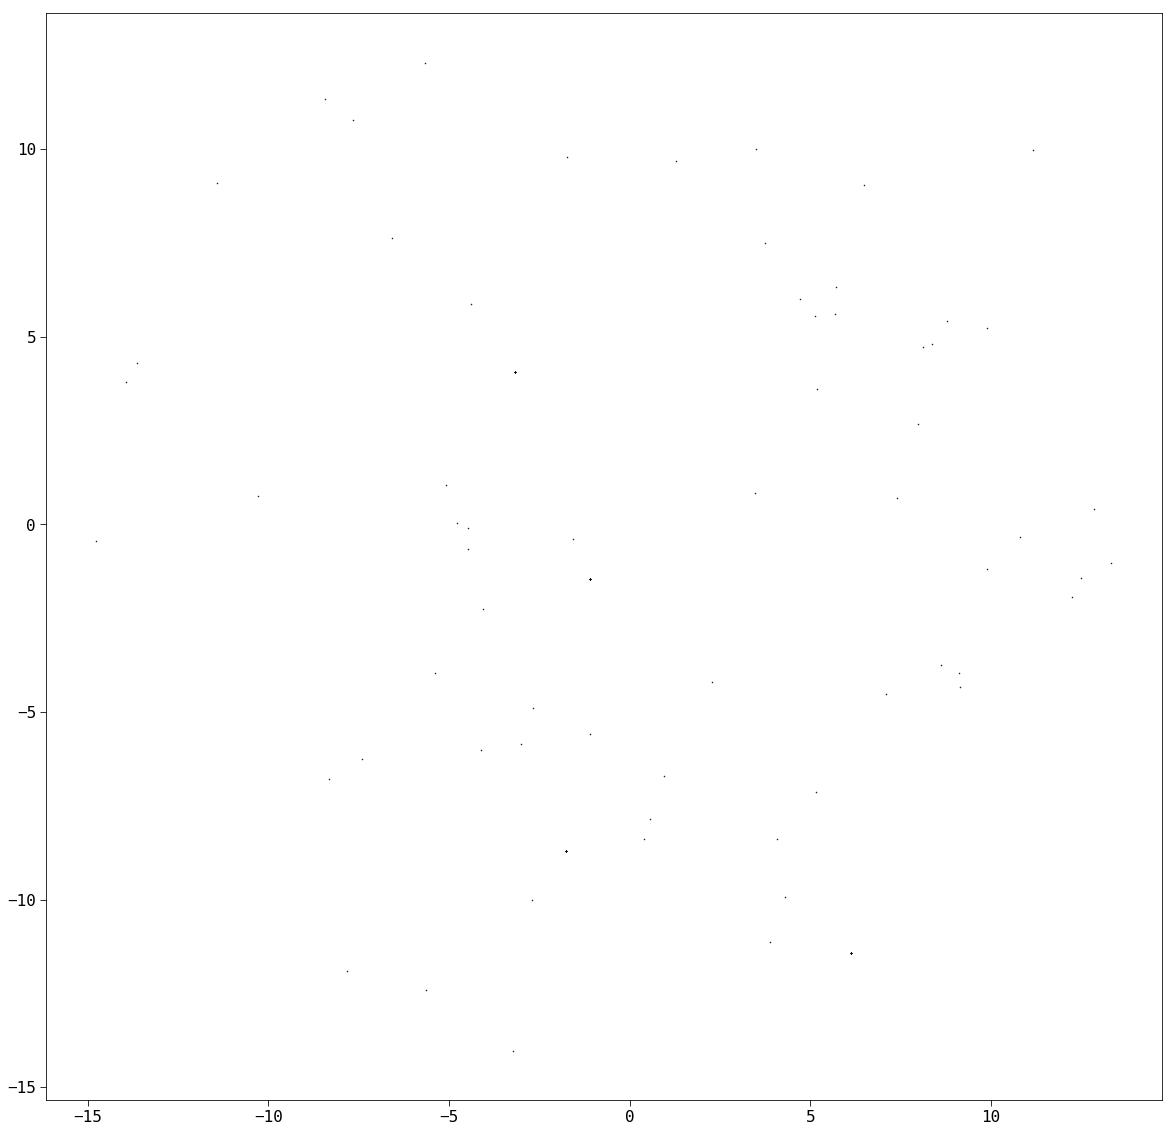

In [100]:
# find collision pairs

`
from scipy.spatial.distance import cdist
fiber_collision_radius = 1.


f = plt.figure(figsize=[20,20])
plt.subplot()


txx = np.array( [t.x for tid, t in g.targets.iteritems()] )
tyy = np.array( [t.y for tid, t in g.targets.iteritems()] )

_ii_sci = map( lambda x : x.startswith('sci') , tclasses )
_ii_sky = map( lambda x : x.startswith('sky') , tclasses )
_ii_cal = map( lambda x : x.startswith('cal') , tclasses )


plt.plot(txx,tyy,'.', ms=1, label='science')
#plt.plot(txx[_ii_sky],tyy[_ii_sky],'b.' , label='sky')
#plt.plot(txx[_ii_cal],tyy[_ii_cal],'yo' , label='cal. star')


N = len(g.targets)
points = zip(txx,tyy)
Y = cdist( points[:N], points[:N] )



# any target separation that is smaller than 2 x the collision radius will be flagged a s collision
cc = Y <= (fiber_collision_radius*2.) 

ncoll = int( (np.sum(cc.flatten()) - N)/2. )

print ("Found  {:d} collision pairs.".format( ncoll  ))


# identify collision pairs
collision_pairs = []
# array of indices
ii = np.arange(N)
for i in range(cc.shape[0]):
    x1,y1 =  txx[i], tyy[i]
    # only iterate over the indeces that are colliding and the upper diagonal in the collision matrix
    jj = ii[ cc[i,:] * ii > i ] 
    for j in jj: 
        if cc[i,j]:
            x2,y2 =  txx[j], tyy[j]
            collision_pairs.append([(ID[i],x1,y1),(ID[j],x2,y2)])
            
            

            
for cp in collision_pairs:
    plt.plot([cp[0][1],cp[1][1]],[cp[0][2],cp[1][2]],'r-')
    #plt.plot(txx[ii_cal],tyy[ii_cal],'yo' , label='cal. star')

print len(collision_pairs)

plt.axis('equal')
l = plt.legend()
l.draw_frame(False)
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.xlim([-50,50])

cc = Y < 6.
print sum(cc.flatten())